## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [3]:
def scores(model, X, y, set_type, return_conf=False):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    #set background color to white
    fig.patch.set_facecolor('white')
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    if return_conf == True:
        return fig, round(acc_score*100,1), round(rec_score*100,1)
    if return_conf == False:
        return round(acc_score*100,1), round(rec_score*100,1)

In [4]:
def cross_val(estimator,X,y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [5]:
#returns a summary of the median train R-squared, median test R-squared, and differential score based
#on the cross validation
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [6]:
def score_model(model, Xtrain, Xtest, ytrain, ytest, log=False):
    '''
    This function takes in a model and the train and test samples and returns
    the train R-squared, test R-squared, and the RMSE
    '''
    if log == False:
        rmse = mean_squared_error(ytest, model.predict(Xtest), squared=False)
    else:
        rmse = mean_squared_error(np.exp(ytest), np.exp(model.predict(Xtest)), squared=False)
    return model.score(Xtrain, ytrain),  model.score(Xtest, ytest), rmse

In [7]:
#returns a summary of the train R-squared, test R-squared, differential between R-squared, and RMSE
def model_summary(train,test,diff,rmse):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-squared value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}. The RMSE of our model predicitons was {round(rmse,2)}"

In [8]:
def actual_vs_predicted(model,X_test,y_test):
    """
    Plots the actual y vs the predicted y
    """
    y_predicted = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=y_test, y=y_predicted)
    ax.set_xlabel("Actual Price Values")
    ax.set_ylabel("Predicted Price Values")
    ax.set_title("Actual vs Predicted")
    
    p1 = max(max(y_test), max(y_predicted))
    p2 = min(min(y_test), min(y_predicted))
    plt.plot([p1, p2], [p1, p2], 'b-')

## Reading In and Reviewing Data Files

In [9]:
df_tsc_price_change = pd.read_csv('data/TSC_Price_Changes.csv')

In [10]:
df_tsc_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SCRUB_ITEM        3886 non-null   int64  
 1   PRICE_START_DATE  3886 non-null   object 
 2   PRICE_END_DATE    3886 non-null   object 
 3   TSC_PRICE         3886 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 121.6+ KB


In [11]:
df_tsc_price_change.head()

,SCRUB_ITEM,PRICE_START_DATE,PRICE_END_DATE,TSC_PRICE
0,1,2019-08-26,2019-10-03,199.99
1,1,2019-10-04,2019-10-08,179.99
2,1,2019-10-09,2019-10-27,199.99
3,1,2019-10-28,2019-10-29,179.99
4,1,2019-10-30,2019-11-05,199.99


In [12]:
df_comp_price_change = pd.read_csv('data/Competitors_Price_Changes.csv')

In [13]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCAN_DATE_TIME               90953 non-null  object 
 1   SCRUB_ITEM                   90953 non-null  int64  
 2   SCRUB_COMPETITOR             90953 non-null  int64  
 3   TSC_PRICE                    90953 non-null  float64
 4   COMPETITOR_PRICE             90953 non-null  float64
 5   CPI_COMPETITIVE_PRICE_INDEX  90953 non-null  float64
 6   COMPETITOR_SHIPPING          51396 non-null  float64
 7   COMPETITOR_REG_PRICE         90953 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.6+ MB


In [14]:
df_comp_price_change.head()

,SCAN_DATE_TIME,SCRUB_ITEM,SCRUB_COMPETITOR,TSC_PRICE,COMPETITOR_PRICE,CPI_COMPETITIVE_PRICE_INDEX,COMPETITOR_SHIPPING,COMPETITOR_REG_PRICE
0,2020-08-06 04:20:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
1,2020-08-06 04:21:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
2,2020-08-07 04:24:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
3,2020-08-07 04:24:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
4,2020-08-08 04:22:00.000,1,1,199.99,205.58,102.7951,0.0,205.58


In [15]:
df_tsc_sales = pd.read_csv('data/TSC_Sales_Data.csv')

In [16]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SCRUB_ITEM      70829 non-null  int64  
 1   TIME_DIM_KEY    70829 non-null  int64  
 2   SCRUB_TRANS_NO  70829 non-null  int64  
 3   TRANS_SEQ_NO    70829 non-null  int64  
 4   UNIT_QTY        70829 non-null  float64
 5   UNIT_PRICE      70829 non-null  float64
 6   UNIT_COST       70829 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.8 MB


In [17]:
df_tsc_sales.head(15)

,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,20180402,1296,2,2.0,322.99,132.97
1,1,20181206,6878,1,1.0,322.99,132.97
2,1,20181210,7010,2,2.0,322.99,132.97
3,1,20190214,8380,2,1.0,322.99,132.97
4,1,20190502,10639,1,2.0,219.99,132.97
5,1,20190515,10987,1,1.0,187.12,132.97
6,1,20190529,11343,1,1.0,187.12,132.97
7,1,20190607,11708,1,1.0,186.75,132.97
8,1,20190610,11788,2,2.0,186.75,132.97
9,1,20190611,11846,1,1.0,186.75,132.97


## Isolating Unique Combinations

In [18]:
df_comp_price_change['SCAN_DATE_TIME'].max()

'2021-08-06 11:48:00.000'

In [19]:
df_tsc_sales['TIME_DIM_KEY'].max()

20210806

In [20]:
df1 = df_comp_price_change[['SCRUB_ITEM', 'SCRUB_COMPETITOR']]
df2 = pd.DataFrame(df_tsc_sales['SCRUB_ITEM'])

In [21]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [22]:
year_month = pd.DataFrame([[2022,1],
              [2022,2],
              [2022,3],
              [2022,4],
              [2022,5],
              [2022,6],
              [2022,7],
              [2022,8],
              [2022,9],
              [2022,10],
              [2022,11],
              [2022,12]])
year_month.rename(columns={0:'YEAR',1:'MONTH'},inplace=True)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 90740
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   SCRUB_ITEM        229 non-null    int64
 1   SCRUB_COMPETITOR  229 non-null    int64
dtypes: int64(2)
memory usage: 5.4 KB


In [24]:
year_month1 = year_month.copy()
i=0
while i < 228:
    year_month1 = pd.concat([year_month1,year_month])
    i+=1
year_month1.reset_index(inplace=True, drop=True)

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 68804
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   SCRUB_ITEM  97 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [26]:
year_month2 = year_month.copy()
i=0
while i < 96:
    year_month2 = pd.concat([year_month2,year_month])
    i+=1
year_month2.reset_index(inplace=True, drop=True)

In [27]:
newdf1 = pd.DataFrame(np.repeat(df1.values,12,axis=0))
newdf1.columns = df1.columns
newdf1.reset_index(inplace=True,drop=True)
newdf1

,SCRUB_ITEM,SCRUB_COMPETITOR
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
2743,97,3
2744,97,3
2745,97,3
2746,97,3


In [28]:
newdf1 = newdf1.merge(year_month1,left_index=True,right_index=True)

In [29]:
newdf2 = pd.DataFrame(np.repeat(df2.values,12,axis=0))
newdf2.columns = df2.columns
newdf2.reset_index(inplace=True, drop=True)
newdf2

,SCRUB_ITEM
0,1
1,1
2,1
3,1
4,1
...,...
1159,97
1160,97
1161,97
1162,97


In [30]:
newdf2 = newdf2.merge(year_month2,left_index=True,right_index=True)

In [31]:
newdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   SCRUB_ITEM        2748 non-null   int64
 1   SCRUB_COMPETITOR  2748 non-null   int64
 2   YEAR              2748 non-null   int64
 3   MONTH             2748 non-null   int64
dtypes: int64(4)
memory usage: 86.0 KB


In [32]:
newdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   SCRUB_ITEM  1164 non-null   int64
 1   YEAR        1164 non-null   int64
 2   MONTH       1164 non-null   int64
dtypes: int64(3)
memory usage: 27.4 KB


## Predicting Comp Price

In [33]:
df_comp_price_change.head()

,SCAN_DATE_TIME,SCRUB_ITEM,SCRUB_COMPETITOR,TSC_PRICE,COMPETITOR_PRICE,CPI_COMPETITIVE_PRICE_INDEX,COMPETITOR_SHIPPING,COMPETITOR_REG_PRICE
0,2020-08-06 04:20:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
1,2020-08-06 04:21:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
2,2020-08-07 04:24:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
3,2020-08-07 04:24:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
4,2020-08-08 04:22:00.000,1,1,199.99,205.58,102.7951,0.0,205.58


In [34]:
df_comp_price_change['COMPETITOR_SHIPPING'].fillna(0,inplace=True)

In [35]:
df_comp_price_change['YEAR'] = pd.to_numeric(df_comp_price_change['SCAN_DATE_TIME'].str[:4], errors='coerce')
df_comp_price_change['MONTH'] = pd.to_numeric(df_comp_price_change['SCAN_DATE_TIME'].str[5:7], errors='coerce')

In [83]:
df_comp_price_change['TOTAL_PRICE'] = df_comp_price_change['COMPETITOR_PRICE'] + df_comp_price_change['COMPETITOR_SHIPPING']

In [37]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCAN_DATE_TIME               90953 non-null  object 
 1   SCRUB_ITEM                   90953 non-null  int64  
 2   SCRUB_COMPETITOR             90953 non-null  int64  
 3   TSC_PRICE                    90953 non-null  float64
 4   COMPETITOR_PRICE             90953 non-null  float64
 5   CPI_COMPETITIVE_PRICE_INDEX  90953 non-null  float64
 6   COMPETITOR_SHIPPING          90953 non-null  float64
 7   COMPETITOR_REG_PRICE         90953 non-null  float64
 8   YEAR                         90953 non-null  int64  
 9   MONTH                        90953 non-null  int64  
 10  TOTAL_PRICE                  90953 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.6+ MB


In [38]:
newdf = df_comp_price_change.drop(['SCAN_DATE_TIME',
                           'COMPETITOR_PRICE',
                           'COMPETITOR_SHIPPING',
                           'COMPETITOR_REG_PRICE',
                           'CPI_COMPETITIVE_PRICE_INDEX'], 
                          axis=1)

In [39]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SCRUB_ITEM        90953 non-null  int64  
 1   SCRUB_COMPETITOR  90953 non-null  int64  
 2   TSC_PRICE         90953 non-null  float64
 3   YEAR              90953 non-null  int64  
 4   MONTH             90953 non-null  int64  
 5   TOTAL_PRICE       90953 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 4.2 MB


In [40]:
X = newdf.drop(['TOTAL_PRICE','TSC_PRICE'], axis=1)
y = newdf['TOTAL_PRICE']

In [41]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42)

In [42]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42)

In [43]:
X_num = [#'TSC_PRICE',
         'YEAR']
X_cat = ['SCRUB_ITEM', 'SCRUB_COMPETITOR', 'MONTH']

In [44]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [45]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('linreg', LinearRegression()) 
    ])

In [46]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['YEAR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM',
                                                   'SCRUB_COMPETITOR',
                                                   'MONTH'])])),
                ('linreg', LinearRegression())])

In [47]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.987, the median R-squared values for the test sets were 0.987. These values resulted in a differential of 0.00016'

In [48]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.987, and the R-squared value for the test set was 0.987. These values resulted in a differential of 0.00016. The RMSE of our model predicitons was 70.46'

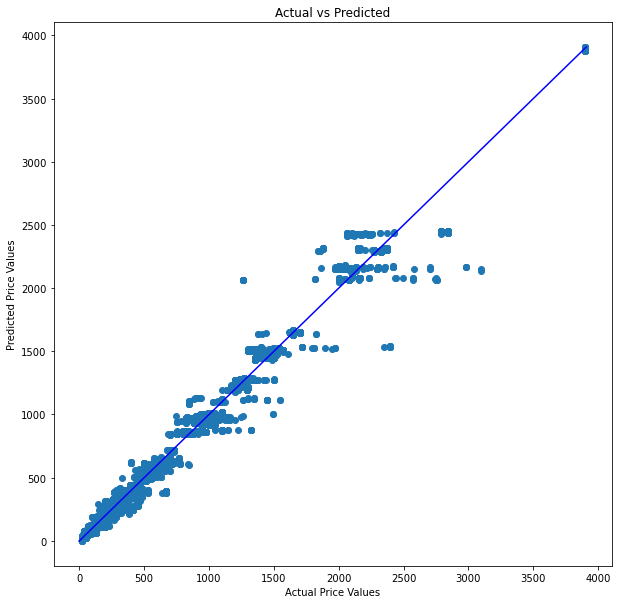

In [49]:
actual_vs_predicted(model1, X_test, y_test)

In [50]:
model1.fit(X,y)
y_preds_comp = model1.predict(newdf1)

In [51]:
df_comp = newdf1.copy()
df_comp['COMP_PRICE'] = y_preds_comp

In [52]:
df_comp

,SCRUB_ITEM,SCRUB_COMPETITOR,YEAR,MONTH,COMP_PRICE
0,1,1,2022,1,211.375000
1,1,1,2022,2,209.968750
2,1,1,2022,3,212.484375
3,1,1,2022,4,212.953125
4,1,1,2022,5,218.578125
...,...,...,...,...,...
2743,97,3,2022,8,91.351562
2744,97,3,2022,9,93.265625
2745,97,3,2022,10,86.664062
2746,97,3,2022,11,76.312500


## Predicting Costs

In [53]:
df_tsc_sales.head()

,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,20180402,1296,2,2.0,322.99,132.97
1,1,20181206,6878,1,1.0,322.99,132.97
2,1,20181210,7010,2,2.0,322.99,132.97
3,1,20190214,8380,2,1.0,322.99,132.97
4,1,20190502,10639,1,2.0,219.99,132.97


In [54]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SCRUB_ITEM      70829 non-null  int64  
 1   TIME_DIM_KEY    70829 non-null  int64  
 2   SCRUB_TRANS_NO  70829 non-null  int64  
 3   TRANS_SEQ_NO    70829 non-null  int64  
 4   UNIT_QTY        70829 non-null  float64
 5   UNIT_PRICE      70829 non-null  float64
 6   UNIT_COST       70829 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.8 MB


In [55]:
df_tsc_sales['TIME_DIM_KEY'] = df_tsc_sales['TIME_DIM_KEY'].astype(str)

In [56]:
df_tsc_sales['YEAR'] = pd.to_numeric(df_tsc_sales['TIME_DIM_KEY'].str[:4], errors='coerce')

In [57]:
df_tsc_sales['MONTH'] = pd.to_numeric(df_tsc_sales['TIME_DIM_KEY'].str[4:6], errors='coerce')

In [58]:
df_tsc_sales.head()

,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST,YEAR,MONTH
0,1,20180402,1296,2,2.0,322.99,132.97,2018,4
1,1,20181206,6878,1,1.0,322.99,132.97,2018,12
2,1,20181210,7010,2,2.0,322.99,132.97,2018,12
3,1,20190214,8380,2,1.0,322.99,132.97,2019,2
4,1,20190502,10639,1,2.0,219.99,132.97,2019,5


In [59]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SCRUB_ITEM      70829 non-null  int64  
 1   TIME_DIM_KEY    70829 non-null  object 
 2   SCRUB_TRANS_NO  70829 non-null  int64  
 3   TRANS_SEQ_NO    70829 non-null  int64  
 4   UNIT_QTY        70829 non-null  float64
 5   UNIT_PRICE      70829 non-null  float64
 6   UNIT_COST       70829 non-null  float64
 7   YEAR            70829 non-null  int64  
 8   MONTH           70829 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 4.9+ MB


In [60]:
newdf = df_tsc_sales.drop(['TIME_DIM_KEY',
                           'SCRUB_TRANS_NO',
                           'TRANS_SEQ_NO',
                           'UNIT_QTY',
                           'UNIT_PRICE'], 
                          axis=1)

In [61]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SCRUB_ITEM  70829 non-null  int64  
 1   UNIT_COST   70829 non-null  float64
 2   YEAR        70829 non-null  int64  
 3   MONTH       70829 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [62]:
X = newdf.drop(['UNIT_COST'], axis=1)
y = newdf['UNIT_COST']

In [63]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42)

In [64]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42)

In [65]:
X_num = ['YEAR']
X_cat = ['SCRUB_ITEM', 'MONTH']

In [66]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [67]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('linreg', LinearRegression()) 
    ])

In [68]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['YEAR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('linreg', LinearRegression())])

In [69]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.994, the median R-squared values for the test sets were 0.995. These values resulted in a differential of 4e-05'

In [70]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.995, and the R-squared value for the test set was 0.994. These values resulted in a differential of 0.0004. The RMSE of our model predicitons was 20.29'

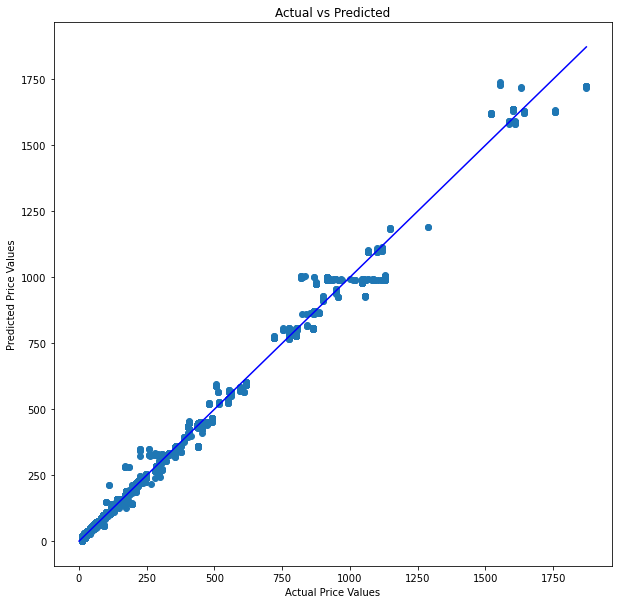

In [71]:
actual_vs_predicted(model1, X_test, y_test)

In [72]:
model1.fit(X,y)
y_preds_cost = model1.predict(newdf2)

In [73]:
df_cost = newdf2.copy()
df_cost['COST'] = y_preds_cost

## Combining Sales and Comp

### Competitor Price

In [74]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCAN_DATE_TIME               90953 non-null  object 
 1   SCRUB_ITEM                   90953 non-null  int64  
 2   SCRUB_COMPETITOR             90953 non-null  int64  
 3   TSC_PRICE                    90953 non-null  float64
 4   COMPETITOR_PRICE             90953 non-null  float64
 5   CPI_COMPETITIVE_PRICE_INDEX  90953 non-null  float64
 6   COMPETITOR_SHIPPING          90953 non-null  float64
 7   COMPETITOR_REG_PRICE         90953 non-null  float64
 8   YEAR                         90953 non-null  int64  
 9   MONTH                        90953 non-null  int64  
 10  TOTAL_PRICE                  90953 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.6+ MB


In [76]:
#getting the first 10 characters of the date to get the Y-m-d
df_comp_price_change['SCAN_DATE_TIME'] = df_comp_price_change['SCAN_DATE_TIME'].str[:10]

In [77]:
df_comp_price_change['SCAN_DATE_TIME'] = pd.to_datetime(df_comp_price_change['SCAN_DATE_TIME'],format='%Y-%m-%d')

In [81]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   SCAN_DATE_TIME               90953 non-null  datetime64[ns]
 1   SCRUB_ITEM                   90953 non-null  int64         
 2   SCRUB_COMPETITOR             90953 non-null  int64         
 3   TSC_PRICE                    90953 non-null  float64       
 4   COMPETITOR_PRICE             90953 non-null  float64       
 5   CPI_COMPETITIVE_PRICE_INDEX  90953 non-null  float64       
 6   COMPETITOR_SHIPPING          90953 non-null  float64       
 7   COMPETITOR_REG_PRICE         90953 non-null  float64       
 8   YEAR                         90953 non-null  int64         
 9   MONTH                        90953 non-null  int64         
 10  TOTAL_PRICE                  90953 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4

In [98]:
comp_df = df_comp_price_change.drop(['CPI_COMPETITIVE_PRICE_INDEX',
                                     'COMPETITOR_REG_PRICE',
                                     'COMPETITOR_SHIPPING',
                                     'COMPETITOR_PRICE',
                                     'YEAR',
                                     'MONTH'],
                                    axis=1)

In [99]:
comp_df.set_index('SCAN_DATE_TIME', inplace=True)

In [100]:
comp_df

,SCRUB_ITEM,SCRUB_COMPETITOR,TSC_PRICE,TOTAL_PRICE
SCAN_DATE_TIME,,,,
2020-08-06,1,1,199.99,205.58
2020-08-06,1,2,199.99,205.58
2020-08-07,1,1,199.99,205.58
2020-08-07,1,2,199.99,205.58
2020-08-08,1,1,199.99,205.58
...,...,...,...,...
2021-08-02,97,2,19.99,27.16
2021-08-03,97,2,19.99,27.16
2021-08-04,97,2,19.99,27.16


In [121]:
grouper =comp_df.groupby([pd.Grouper(freq='W'), 'SCRUB_ITEM'])

In [125]:
grouper['TSC_PRICE'].mean()

SCAN_DATE_TIME  SCRUB_ITEM
2020-08-09      1             199.990000
                2              14.990000
                3             179.990000
                4             309.950000
                5             129.990000
                                 ...    
2021-08-08      93            229.990000
                94            313.323333
                95            249.990000
                96            499.990000
                97             19.990000
Name: TSC_PRICE, Length: 4789, dtype: float64

In [138]:
result_price = grouper['TSC_PRICE'].mean()

In [141]:
result_price = result_price.reset_index()

In [147]:
result_price

,SCAN_DATE_TIME,SCRUB_ITEM,TSC_PRICE
0,2020-08-09,1,199.990000
1,2020-08-09,2,14.990000
2,2020-08-09,3,179.990000
3,2020-08-09,4,309.950000
4,2020-08-09,5,129.990000
...,...,...,...
4784,2021-08-08,93,229.990000
4785,2021-08-08,94,313.323333
4786,2021-08-08,95,249.990000
4787,2021-08-08,96,499.990000


In [135]:
result_comp = grouper['TOTAL_PRICE'].mean()

In [143]:
result_comp = result_comp.reset_index()

In [148]:
result_comp

,SCAN_DATE_TIME,SCRUB_ITEM,TOTAL_PRICE
0,2020-08-09,1,205.477500
1,2020-08-09,2,22.575000
2,2020-08-09,3,157.258000
3,2020-08-09,4,309.950000
4,2020-08-09,5,129.990000
...,...,...,...
4784,2021-08-08,93,206.022143
4785,2021-08-08,94,315.520000
4786,2021-08-08,95,272.210000
4787,2021-08-08,96,461.760000


In [145]:
df_comp_mod = result_price.merge(result_comp, on=['SCAN_DATE_TIME','SCRUB_ITEM'])

In [146]:
df_comp_mod

,SCAN_DATE_TIME,SCRUB_ITEM,TSC_PRICE,TOTAL_PRICE
0,2020-08-09,1,199.990000,205.477500
1,2020-08-09,2,14.990000,22.575000
2,2020-08-09,3,179.990000,157.258000
3,2020-08-09,4,309.950000,309.950000
4,2020-08-09,5,129.990000,129.990000
...,...,...,...,...
4784,2021-08-08,93,229.990000,206.022143
4785,2021-08-08,94,313.323333,315.520000
4786,2021-08-08,95,249.990000,272.210000
4787,2021-08-08,96,499.990000,461.760000


In [163]:
df_comp_mod.rename(columns={'SCAN_DATE_TIME': 'WEEK'}, inplace=True)

### Sales Data

In [149]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SCRUB_ITEM      70829 non-null  int64         
 1   TIME_DIM_KEY    70829 non-null  datetime64[ns]
 2   SCRUB_TRANS_NO  70829 non-null  int64         
 3   TRANS_SEQ_NO    70829 non-null  int64         
 4   UNIT_QTY        70829 non-null  float64       
 5   UNIT_PRICE      70829 non-null  float64       
 6   UNIT_COST       70829 non-null  float64       
 7   YEAR            70829 non-null  int64         
 8   MONTH           70829 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 4.9 MB


In [79]:
df_tsc_sales['TIME_DIM_KEY'] = pd.to_datetime(df_tsc_sales['TIME_DIM_KEY'],format='%Y%m%d')

In [80]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SCRUB_ITEM      70829 non-null  int64         
 1   TIME_DIM_KEY    70829 non-null  datetime64[ns]
 2   SCRUB_TRANS_NO  70829 non-null  int64         
 3   TRANS_SEQ_NO    70829 non-null  int64         
 4   UNIT_QTY        70829 non-null  float64       
 5   UNIT_PRICE      70829 non-null  float64       
 6   UNIT_COST       70829 non-null  float64       
 7   YEAR            70829 non-null  int64         
 8   MONTH           70829 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 4.9 MB


In [150]:
sales_df = df_tsc_sales.drop(['SCRUB_TRANS_NO','TRANS_SEQ_NO','YEAR','MONTH'], axis=1)

In [153]:
sales_df.set_index('TIME_DIM_KEY', inplace=True)

In [154]:
grouper = sales_df.groupby([pd.Grouper(freq='W'), 'SCRUB_ITEM'])

In [155]:
result_quant = grouper['UNIT_QTY'].sum()
result_quant = result_quant.reset_index()

In [156]:
result_price = grouper['UNIT_PRICE'].mean()
result_price = result_price.reset_index()

In [157]:
result_cost = grouper['UNIT_COST'].mean()
result_cost = result_cost.reset_index()

In [158]:
df_sales_mod = result_quant.merge(result_price, on=['TIME_DIM_KEY','SCRUB_ITEM'])
df_sales_mod = df_sales_mod.merge(result_cost, on=['TIME_DIM_KEY','SCRUB_ITEM'])

In [162]:
df_sales_mod.rename(columns={'TIME_DIM_KEY': 'WEEK'}, inplace=True)

### Merge Both Datasets

In [286]:
df_sales_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8351 entries, 0 to 8350
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   WEEK        8351 non-null   datetime64[ns]
 1   SCRUB_ITEM  8351 non-null   int64         
 2   UNIT_QTY    8351 non-null   float64       
 3   UNIT_PRICE  8351 non-null   float64       
 4   UNIT_COST   8351 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 391.5 KB


In [287]:
df_comp_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 4788
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         4789 non-null   datetime64[ns]
 1   SCRUB_ITEM   4789 non-null   int64         
 2   TSC_PRICE    4789 non-null   float64       
 3   TOTAL_PRICE  4789 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 187.1 KB


In [288]:
merged_df_outer = df_sales_mod.merge(df_comp_mod, on=['WEEK','SCRUB_ITEM'],how='outer',suffixes=('_sales', '_comp'))

In [289]:
merged_df_inner = df_sales_mod.merge(df_comp_mod, on=['WEEK','SCRUB_ITEM'],how='inner',suffixes=('_sales', '_comp'))

In [290]:
merged_df_outer.sort_values(by=['WEEK','SCRUB_ITEM'],inplace=True)

In [291]:
merged_df_outer.reset_index(inplace=True, drop=True)

In [292]:
merged_df_outer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         10045 non-null  datetime64[ns]
 1   SCRUB_ITEM   10045 non-null  int64         
 2   UNIT_QTY     8351 non-null   float64       
 3   UNIT_PRICE   8351 non-null   float64       
 4   UNIT_COST    8351 non-null   float64       
 5   TSC_PRICE    4789 non-null   float64       
 6   TOTAL_PRICE  4789 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 549.5 KB


In [293]:
merged_df_outer['UNIT_QTY'].fillna(0,inplace=True)

In [294]:
outer_groupby = merged_df_outer.groupby(by=['WEEK','SCRUB_ITEM']).mean()

In [295]:
outer_groupby.ffill(inplace=True)

In [296]:
outer_groupby.reset_index(inplace=True)

In [297]:
df_outer = outer_groupby.dropna()

In [298]:
df_outer

,WEEK,SCRUB_ITEM,UNIT_QTY,UNIT_PRICE,UNIT_COST,TSC_PRICE,TOTAL_PRICE
5047,2020-08-09,1,8.0,199.99,132.97,199.990000,205.477500
5048,2020-08-09,2,19.0,14.99,10.99,14.990000,22.575000
5049,2020-08-09,3,5.0,179.99,101.50,179.990000,157.258000
5050,2020-08-09,4,0.0,179.99,101.50,309.950000,309.950000
5051,2020-08-09,5,6.0,128.99,100.00,129.990000,129.990000
...,...,...,...,...,...,...,...
10040,2021-08-08,93,2.0,229.99,155.00,229.990000,206.022143
10041,2021-08-08,94,12.0,319.99,222.60,313.323333,315.520000
10042,2021-08-08,95,0.0,319.99,222.60,249.990000,272.210000
10043,2021-08-08,96,0.0,319.99,222.60,499.990000,461.760000


## Modeling Quantity

In [299]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 5047 to 10044
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         4998 non-null   datetime64[ns]
 1   SCRUB_ITEM   4998 non-null   int64         
 2   UNIT_QTY     4998 non-null   float64       
 3   UNIT_PRICE   4998 non-null   float64       
 4   UNIT_COST    4998 non-null   float64       
 5   TSC_PRICE    4998 non-null   float64       
 6   TOTAL_PRICE  4998 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 312.4 KB


In [300]:
df_outer['WEEK_STR'] = df_outer['WEEK'].astype('str')

<ipython-input-300-a77f97a428dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outer['WEEK_STR'] = df_outer['WEEK'].astype('str')


In [301]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 5047 to 10044
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         4998 non-null   datetime64[ns]
 1   SCRUB_ITEM   4998 non-null   int64         
 2   UNIT_QTY     4998 non-null   float64       
 3   UNIT_PRICE   4998 non-null   float64       
 4   UNIT_COST    4998 non-null   float64       
 5   TSC_PRICE    4998 non-null   float64       
 6   TOTAL_PRICE  4998 non-null   float64       
 7   WEEK_STR     4998 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 351.4+ KB


In [302]:
df_outer.head()

,WEEK,SCRUB_ITEM,UNIT_QTY,UNIT_PRICE,UNIT_COST,TSC_PRICE,TOTAL_PRICE,WEEK_STR
5047,2020-08-09,1,8.0,199.99,132.97,199.99,205.4775,2020-08-09
5048,2020-08-09,2,19.0,14.99,10.99,14.99,22.5750,2020-08-09
5049,2020-08-09,3,5.0,179.99,101.50,179.99,157.2580,2020-08-09
5050,2020-08-09,4,0.0,179.99,101.50,309.95,309.9500,2020-08-09
5051,2020-08-09,5,6.0,128.99,100.00,129.99,129.9900,2020-08-09


In [303]:
df_outer['MONTH'] = df_outer['WEEK_STR'].str[5:7].astype(int)
df_outer['YEAR'] = df_outer['WEEK_STR'].str[:4].astype(int)

<ipython-input-303-b703266e9ea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outer['MONTH'] = df_outer['WEEK_STR'].str[5:7].astype(int)
<ipython-input-303-b703266e9ea4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outer['YEAR'] = df_outer['WEEK_STR'].str[:4].astype(int)


In [304]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 5047 to 10044
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         4998 non-null   datetime64[ns]
 1   SCRUB_ITEM   4998 non-null   int64         
 2   UNIT_QTY     4998 non-null   float64       
 3   UNIT_PRICE   4998 non-null   float64       
 4   UNIT_COST    4998 non-null   float64       
 5   TSC_PRICE    4998 non-null   float64       
 6   TOTAL_PRICE  4998 non-null   float64       
 7   WEEK_STR     4998 non-null   object        
 8   MONTH        4998 non-null   int64         
 9   YEAR         4998 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 429.5+ KB


In [305]:
new_outer= df_outer.drop(['WEEK','WEEK_STR'], axis=1)

In [306]:
new_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 5047 to 10044
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SCRUB_ITEM   4998 non-null   int64  
 1   UNIT_QTY     4998 non-null   float64
 2   UNIT_PRICE   4998 non-null   float64
 3   UNIT_COST    4998 non-null   float64
 4   TSC_PRICE    4998 non-null   float64
 5   TOTAL_PRICE  4998 non-null   float64
 6   MONTH        4998 non-null   int64  
 7   YEAR         4998 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 351.4 KB


In [307]:
X = new_outer.drop(['UNIT_QTY', 'UNIT_COST', 'TSC_PRICE'], axis=1)
y = new_outer['UNIT_QTY']

In [308]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42)

In [309]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42)

In [310]:
X_num = ['YEAR', 
         'UNIT_PRICE', 
         #'UNIT_COST', 
         #'TSC_PRICE', 
         'TOTAL_PRICE']
X_cat = ['SCRUB_ITEM', 'MONTH']

In [311]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [312]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('linreg', LinearRegression()) 
    ])

In [313]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['YEAR', 'UNIT_PRICE',
                                                   'TOTAL_PRICE']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('linreg', LinearRegression())])

In [314]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.293, the median R-squared values for the test sets were 0.271. These values resulted in a differential of 0.02157'

In [315]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.293, and the R-squared value for the test set was 0.191. These values resulted in a differential of 0.10264. The RMSE of our model predicitons was 16.31'

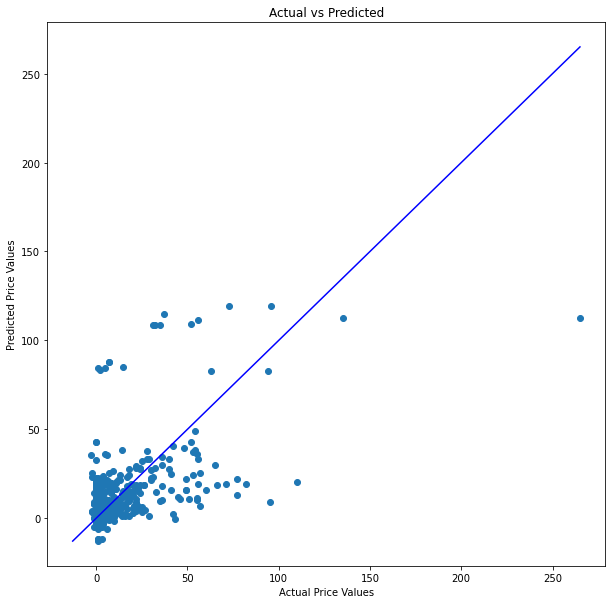

In [316]:
actual_vs_predicted(model1, X_test, y_test)

In [317]:
model1.fit(X,y)
y_preds_quant = model1.predict(new_outer)

ValueError: X has 8 features, but ColumnTransformer is expecting 5 features as input.